<a href="https://colab.research.google.com/github/CYaiche/Machine_Learning/blob/master/projet5/embedding_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Supervised topic modeling : NN approach



In this notebook, I tested two different embeddings (third one, BERT in the third notebook) which are **Word2Vec** and **USE** embedding. 
I will train Word2Vec on my corpus and use a pre-trained USE embedding. 

For the classification, I trained a multi-layer perceptron. 
I evaluate both model with the same score as the first notebook : the average precision score and the jaccard score. I also plot confusion matrix for some specific classes. 

In [74]:
%load_ext autoreload
%autoreload 2
from  tm_common import *
IN_COLAB, output_dir = tm_get_working_config()
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim.corpora as corpora
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

from sklearn.preprocessing import MultiLabelBinarizer
from keras.utils import pad_sequences
from sklearn.metrics import jaccard_score, average_precision_score
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Flatten,
    Embedding,
    Dense,
    Input,
    Embedding,
    GlobalAveragePooling1D,
)

from sentence_transformers import SentenceTransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print("Python version used : ", sys.version[:7])
print("Tensorflow  : ", tf.version.VERSION)

Python version used :  3.8.10 
Tensorflow  :  2.10.1


In [75]:
X_train, X_test, y_train, y_test = tm_load_train_test_set(output_dir)

X_corpus_train, X_corpus_test = tm_load_train_test_set(output_dir, option="raw_corpus")
label_list = tm_get_label_list(output_dir)

In [76]:
X_train, y_train = tm_get_subset(X_train, y_train)
X_test, y_test = tm_get_subset(X_test, y_test)
X_corpus_train = tm_get_subsetX(X_corpus_train)
X_corpus_test = tm_get_subsetX(X_corpus_test)

In [77]:
print( len(X_test) ) 
print( len(y_test) )
print( len(y_train))
print( len(X_train))
print( len(X_corpus_train))
print( len(X_corpus_test))

1545
1545
6182
6182
6182
1545


In [55]:
X_corpus_train, X_corpus_test = tm_get_subset(X_corpus_train, X_corpus_test)

In [5]:
y_train_b, y_test_b = tm_multilabel_binarizer(y_train, y_test)

# Neural Networks

Multilayers perceptron (MLP) for multi-label classification


# Embedding preprocessing

In [6]:
X_train_list = [ x.tolist() for x in X_train]

In [7]:
#  Word2Vec model creation
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences

sentences = X_train_list

print("Build & train Word2Vec model ...")
w2v_model = Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)

Build & train Word2Vec model ...


In [8]:
try:
    model_vectors = KeyedVectors.load(f"{output_dir}model_vector.wv", mmap="r")
except:
    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv

    model_vectors.save(f"{output_dir}model_vector.wv")

In [9]:
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 370103
Word2Vec trained


In [10]:
print(w2v_model)

Word2Vec<vocab=0, vector_size=300, alpha=0.025>


In [11]:
d = dict(zip(label_list, range(0,len(label_list))))

In [12]:
id2word = corpora.Dictionary(X_train)
x_train_ids = [ id2word.doc2idx(tokens) for tokens in X_train]

x_test_ids = [ id2word.doc2idx(tokens) for tokens in X_test  ]
# Filter out -1 from x_test_ids
filtered_x_test_ids = [[word_id for word_id in sentence if word_id != -1] for sentence in x_test_ids]



In [13]:
max_length = np.max([ len(x) for x in x_train_ids])
print(f"max_length : {max_length}")

max_length : 1862


# Embedding matrix

In [14]:
len(model_vectors[0])

300

In [15]:
word2vec_vocab_size = len(model_vectors.key_to_index)
w2vec_dim = len(model_vectors[0])
word2vec_embedding_matrix = np.zeros((word2vec_vocab_size, w2vec_dim))

for word in model_vectors.key_to_index:
    embedding_vector = model_vectors[word]
    if embedding_vector is not None:
        idx = model_vectors.key_to_index[word]
        word2vec_embedding_matrix[idx] = embedding_vector

print("Embedding matrix: %s" % str(word2vec_embedding_matrix.shape))

Embedding matrix: (370103, 300)


# Apply padding

In [16]:
x_train_pad = pad_sequences(x_train_ids, maxlen=max_length, padding='pre',value=0)
x_test_pad = pad_sequences(filtered_x_test_ids, maxlen=max_length, padding='pre',value=0)


In [17]:
model = Sequential()
# model.add(Input(shape=(1,max_length),dtype='float64'))
model.add(Embedding( word2vec_vocab_size, w2vec_dim,weights=[word2vec_embedding_matrix],  input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(30,activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1862, 300)         111030900 
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 30)                9030      
                                                                 
Total params: 111,039,930
Trainable params: 111,039,930
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
model.fit(x_train_pad, y_train_b, batch_size=128, epochs=5)

Epoch 1/5
49/49 [==============================] - 56s 1s/step - loss: 0.2914 - accuracy: 0.1186
Epoch 2/5
49/49 [==============================] - 55s 1s/step - loss: 0.1996 - accuracy: 0.1600
Epoch 3/5
49/49 [==============================] - 55s 1s/step - loss: 0.1984 - accuracy: 0.1576
Epoch 4/5
49/49 [==============================] - 55s 1s/step - loss: 0.1987 - accuracy: 0.1567
Epoch 5/5
49/49 [==============================] - 56s 1s/step - loss: 0.1985 - accuracy: 0.1529


In [20]:
y_pred = model.predict(x_train_pad)
threshold_test = tm_test_threshold(y_train_b, y_pred)  


194/194 [==============================] - 4s 20ms/step


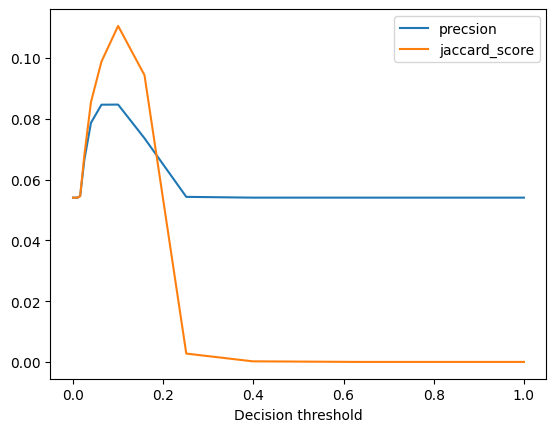

In [21]:
tm_plot_threshold_test(threshold_test)

In [22]:

max_config = threshold_test.query('precision == precision.max()')
t = max_config["threshold"]
best_t =  t.values[0]

best_t

0.09999999999999346

In [23]:
y_pred = model.predict(x_test_pad)
y_pred_nn = (y_pred > best_t).astype(np.float32)

49/49 [==============================] - 1s 19ms/step


In [24]:

precision_w2v      = average_precision_score(y_test_b, y_pred_nn, average='micro')
jaccard_score_w2v = jaccard_score(y_test_b, y_pred_nn, average='micro')

The vocab is the number of unique words in my train data.
The size is the dimension in output of my embedding.

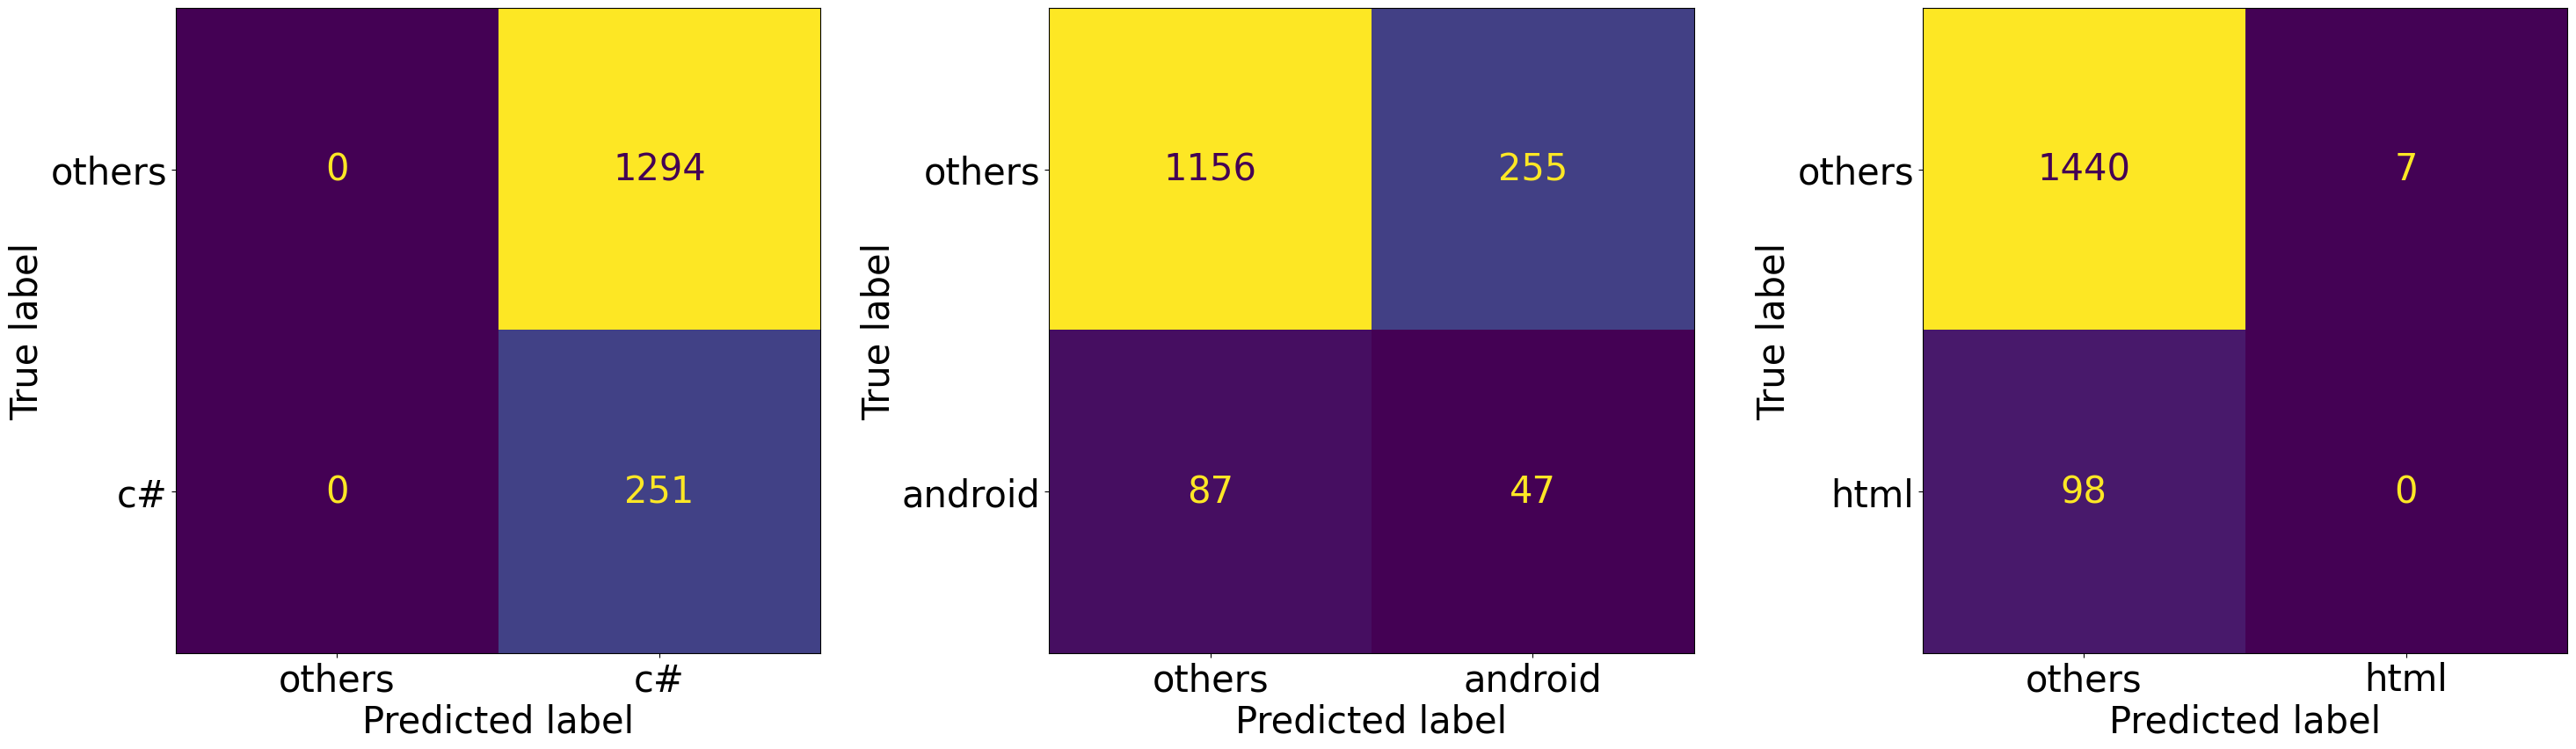

In [45]:
plot_confusion_matrix(y_test_b, y_pred_nn, label_list)

In [35]:
print(classification_report(y_test_b, y_pred_nn, target_names=label_list, digits=2))

                precision    recall  f1-score   support

            c#       0.16      1.00      0.28       251
          java       0.15      1.00      0.27       236
           c++       0.11      1.00      0.20       176
    javascript       0.13      1.00      0.23       205
        python       0.00      0.00      0.00       174
       android       0.16      0.35      0.22       134
           ios       0.05      0.01      0.02       110
          .net       0.07      0.01      0.01       123
           php       0.00      0.00      0.00        79
             c       0.06      0.01      0.02        86
          html       0.00      0.00      0.00        98
        jquery       0.00      0.00      0.00        66
   performance       0.25      0.01      0.02        77
           css       0.00      0.00      0.00        68
   objective-c       0.00      0.00      0.00        39
         c++11       0.00      0.00      0.00        46
       asp.net       0.00      0.00      0.00  

The support is clearly correlated to the precision here, which is less than the SVM one, the embedding clearly lacks of training. For next embedding, I will use a pre-train one. 

# USE : Universal Sentence Encoder 
encodes into high-dimensional vectors, trained on variety of data and output 512 dimensional vector

# apply padding to words 

In [36]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [78]:
X_train_use_embedding = embed(X_corpus_train.tolist())
X_test_use_embedding = embed(X_corpus_test.tolist())

In [79]:
use_model = Sequential()
use_model.add(Dense(256, activation='relu', input_dim=512))
use_model.add(Dense(128, activation='relu'))
use_model.add(Dense(30,activation='sigmoid'))
# Compile the model
use_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
use_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 30)                3870      
                                                                 
Total params: 168,094
Trainable params: 168,094
Non-trainable params: 0
_________________________________________________________________


In [80]:
use_model.fit(X_train_use_embedding, y_train_b, batch_size = 128, epochs=100)

Epoch 1/100
49/49 [==============================] - 1s 3ms/step - loss: 0.3518 - accuracy: 0.1301
Epoch 2/100
49/49 [==============================] - 0s 3ms/step - loss: 0.1786 - accuracy: 0.4397
Epoch 3/100
49/49 [==============================] - 0s 3ms/step - loss: 0.1419 - accuracy: 0.6250
Epoch 4/100
49/49 [==============================] - 0s 3ms/step - loss: 0.1111 - accuracy: 0.6978
Epoch 5/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0960 - accuracy: 0.7273
Epoch 6/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0878 - accuracy: 0.7329
Epoch 7/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0823 - accuracy: 0.7407
Epoch 8/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0784 - accuracy: 0.7383
Epoch 9/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0755 - accuracy: 0.7422
Epoch 10/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0732 - accuracy: 0.7407
Epoch 11/

In [81]:
y_pred = use_model.predict(X_train_use_embedding[:100])
threshold_test_use = tm_test_threshold(y_train_b[:100], y_pred)  

4/4 [==============================] - 0s 2ms/step


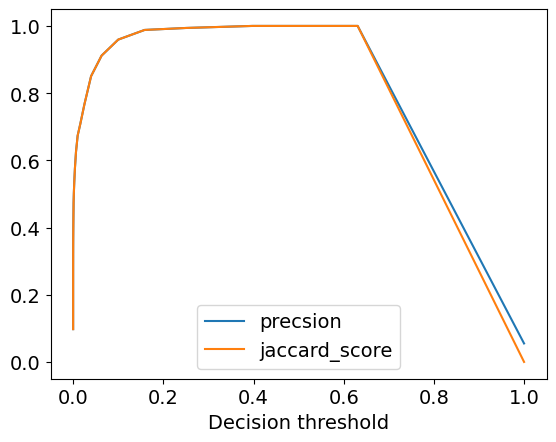

In [82]:
tm_plot_threshold_test(threshold_test_use)

In [83]:
max_config = threshold_test_use.query('precision == precision.max()')
t = max_config["threshold"]
best_t =  t.values[0]
best_t

0.3981071705534692

In [84]:
y_test_b.shape

(1545, 30)

In [85]:
X_test_use_embedding.shape

TensorShape([1545, 512])

In [86]:
y_pred_use = use_model.predict(X_test_use_embedding)
y_pred_use = (y_pred_use > best_t).astype(np.float32)
precision_use      = average_precision_score(y_test_b, y_pred_use, average='micro')
jaccard_score_use = jaccard_score(y_test_b, y_pred_use, average='micro')


49/49 [==============================] - 0s 941us/step


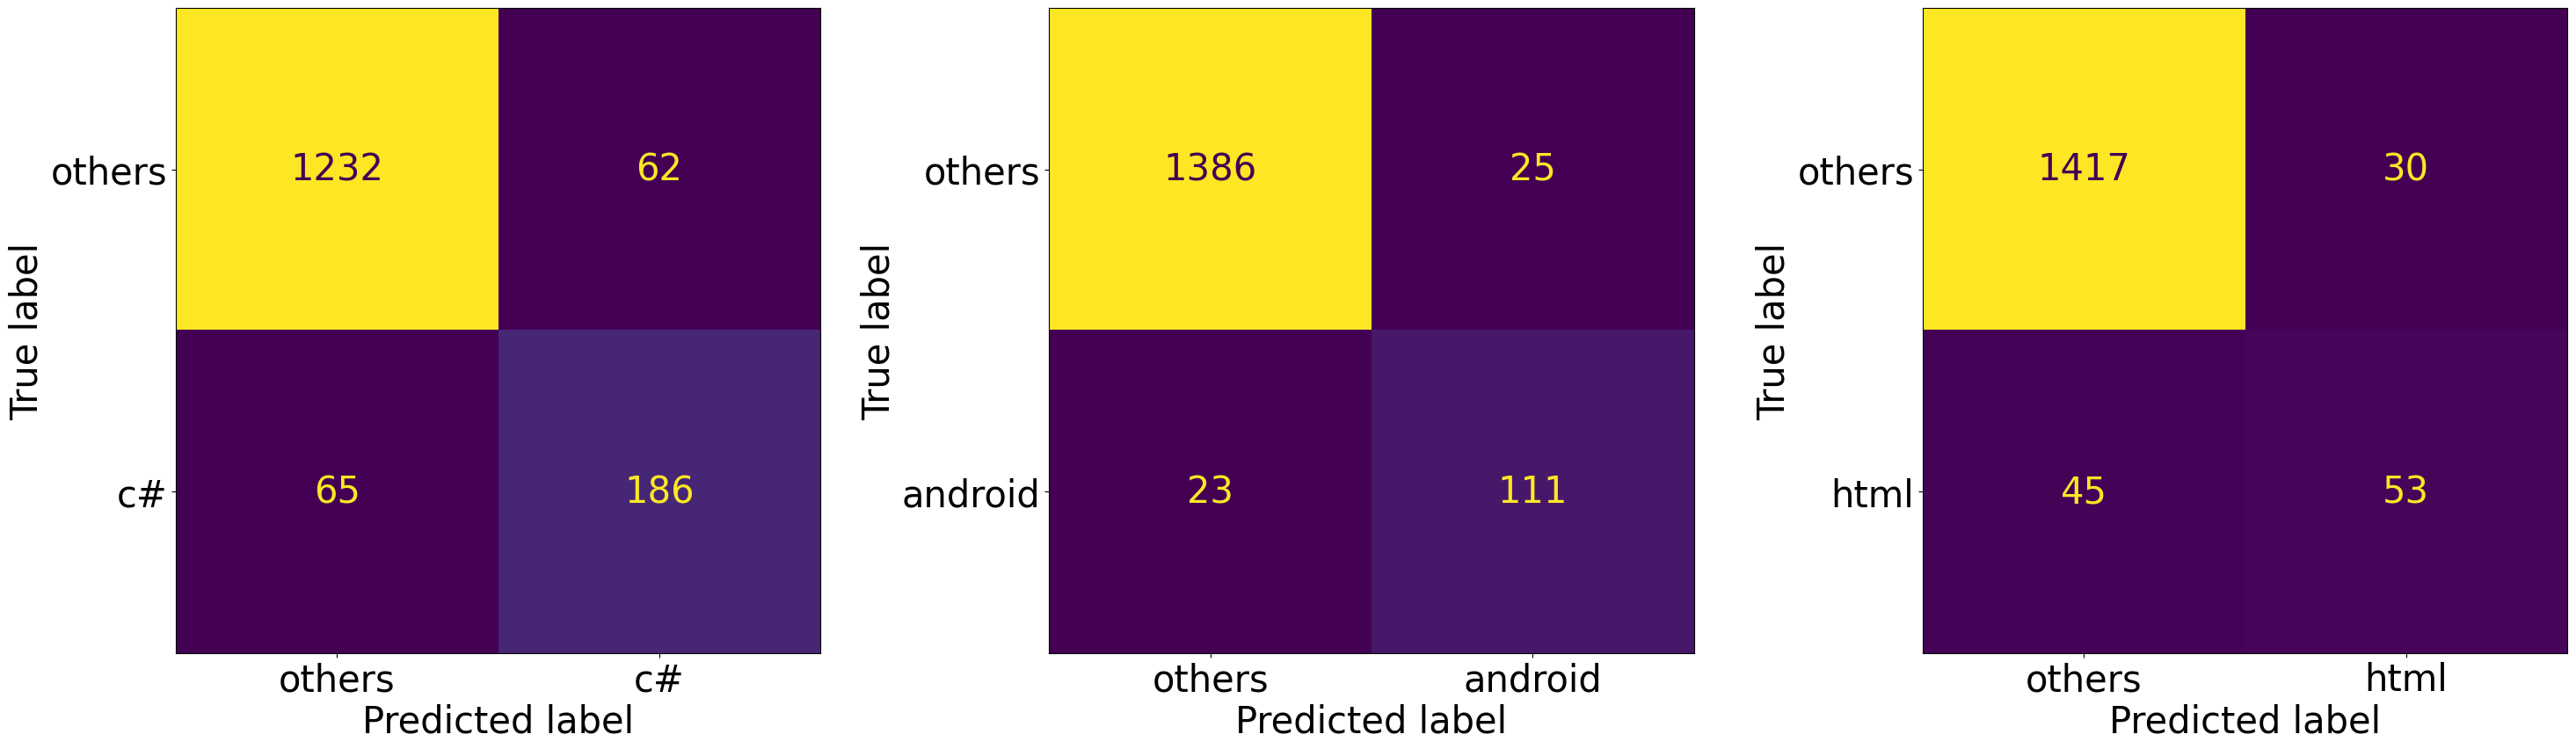

In [89]:
plot_confusion_matrix(y_test_b, y_pred_use, label_list)

In [90]:
print(classification_report(y_test_b, y_pred_use, target_names=label_list, digits=2))

                precision    recall  f1-score   support

            c#       0.75      0.74      0.75       251
          java       0.76      0.81      0.78       236
           c++       0.75      0.75      0.75       176
    javascript       0.77      0.75      0.76       205
        python       0.90      0.86      0.88       174
       android       0.82      0.83      0.82       134
           ios       0.79      0.74      0.76       110
          .net       0.47      0.38      0.42       123
           php       0.71      0.71      0.71        79
             c       0.62      0.60      0.61        86
          html       0.64      0.54      0.59        98
        jquery       0.62      0.71      0.66        66
   performance       0.49      0.36      0.42        77
           css       0.78      0.66      0.71        68
   objective-c       0.42      0.46      0.44        39
         c++11       0.42      0.22      0.29        46
       asp.net       0.31      0.23      0.26  

c:\dev\topic_modelling\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Evaluation 

In [91]:
avg_precision_scores = [precision_w2v, precision_use,]
jaccard_scores = [jaccard_score_w2v, jaccard_score_use]
result = pd.DataFrame(
    {
        'average_precision_scores' : avg_precision_scores,
        'jaccard_scores' : jaccard_scores
    }, index = ['Word2Vec','USE']
)
result.to_csv(f"{output_dir}result_supervised2.csv")

In [92]:
result

,average_precision_scores,jaccard_scores
Word2Vec,0.085256,0.112318
USE,0.463946,0.500000
